# Введение в метод сопряжённых градиентов

Вы будете решать простую квадратичную задачу оптимизации положения мобильных роботов, сравнивая **градиентный спуск (GD)** и **метод сопряжённых градиентов (CG)** для определения их оптимальных положений. 

## Сюжет задачи

Есть команда роботов. Некоторые — **неподвижные** (фиксированные), остальные — **мобильные**. 
Пары роботов, которым нужно обмениваться данными, заданы **неориентированным графом** $G=(V,E)$. 

**Пояснение:** Здесь $V$ - множество всех роботов, можно рассматривать его как множество координат $p_i\in\mathbb{R}^2$. А $E$ - множество рёбер, которое задаёт пары роботов, которые обмениваются данными. Например, если $V=\{(1.0, 1.0), (-2.0, 2.0), (3.0, 0.0), (1.0, -2.0)\}$ и $E=\{(1,2),(2,3),(3,4),(4,1)\}$, то робот 1 обменивается данными с роботом 2, 2 с 3, 3 с 4, 4 с 1.

Обратите внимание, что не всем роботам нужно обмениваться данными со всеми остальными.

Но для тех, кому нужно обмениваться, важно, чтобы они были близко друг к другу. Цена связи между двумя роботами растёт с расстоянием, поэтому мы минимизируем сумму квадратов расстояний между соединёнными вершинами графа, при этом координаты фиксированных роботов неизменны.

Мы работаем в 2D: позиция робота $i$ — это вектор $p_i\in\mathbb{R}^2$.

Обозначим множество фиксированных роботов через $F\subset V$. Тогда оптимизационная задача:
$$
\min_{\{p_i\}_{i\in V\setminus F}}  \frac{1}{2}\sum_{(i,j)\in E}\|p_i-p_j\|_2^2
\quad \text{при} \quad p_k=f_k \;\; \forall k\in F.
$$
Ниже предствален код для отрисовки такой системы для заданного множества фиксированных роботов $F$ и подсчёта значения функции потерь для конкретного положения роботов.

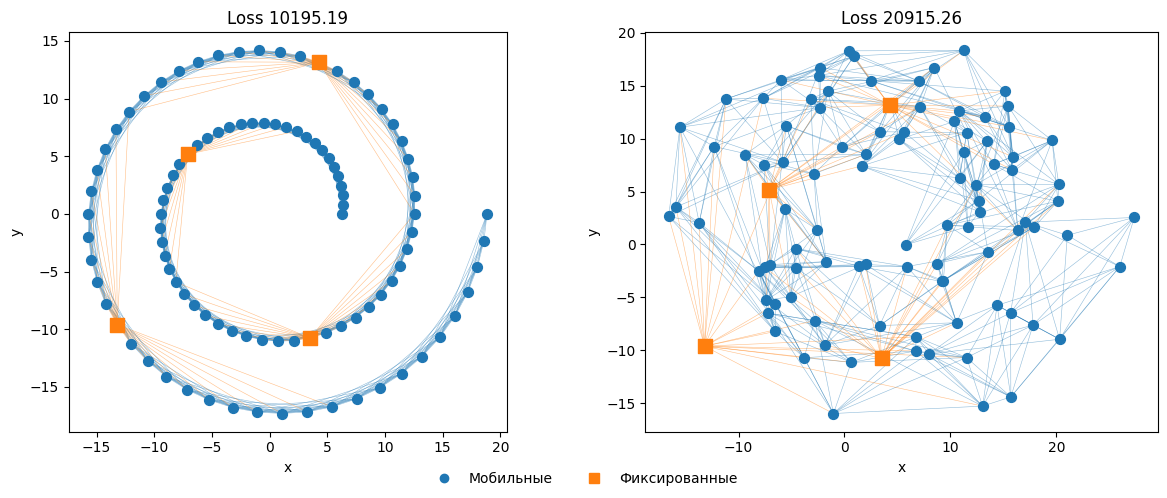

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

rng = np.random.default_rng(0)

def make_spiral_positions(N, t_min=2*np.pi, t_max=6*np.pi):
    t = np.linspace(t_min, t_max, N)
    return np.stack([t*np.cos(t), t*np.sin(t)], axis=1)

def build_edges(N, fixed, mob_span=5, fix_span=10):
    E = set()
    for i in range(N):
        span = fix_span if i in fixed else mob_span
        lo, hi = max(0,i-span), min(N,i+span+1)
        for j in range(lo,hi):
            if i!=j: E.add(tuple(sorted((i,j))))
    return sorted(E)

def loss_edges(P, E):
    s=0.0
    for i,j in E:
        d = P[i]-P[j]
        s += 0.5*float(d@d)
    return s

# ---- данные
N = 101
F = {20,40,60,80}
P0 = make_spiral_positions(N)
E  = build_edges(N, F, mob_span=5, fix_span=10)

# классифицируем рёбра
fixed_set = set(F)
E_fixed  = [(i,j) for (i,j) in E if (i in fixed_set or j in fixed_set)]
E_mobile = [(i,j) for (i,j) in E if (i not in fixed_set and j not in fixed_set)]

# возмущаем только мобильных
P1 = P0.copy()
noise = 10.0*(rng.random(P1.shape)-0.1)
for i in range(N):
    if i not in F: P1[i] += noise[i]

def plot_2_examples(P1, P2, N, F, E, titles=None):
    fixed_set = set(F)
    E_fixed  = [(i,j) for (i,j) in E if (i in fixed_set or j in fixed_set)]
    E_mobile = [(i,j) for (i,j) in E if (i not in fixed_set and j not in fixed_set)]
    mob_idx = [i for i in range(N) if i not in fixed_set]
    fix_idx = list(F)

    def draw_on_ax(P, ax, title):
        # рёбра между мобильными — C0
        for i,j in E_mobile:
            seg = np.vstack([P[i],P[j]])
            ax.plot(seg[:,0], seg[:,1], linewidth=0.4, color='C0', zorder=1, alpha=0.5)
        # рёбра с фиксированными — C1
        for i,j in E_fixed:
            seg = np.vstack([P[i],P[j]])
            ax.plot(seg[:,0], seg[:,1], linewidth=0.4, color='C1', zorder=1, alpha=0.5)

        # вершины
        ax.scatter(P[mob_idx,0], P[mob_idx,1], s=50, zorder=2, color='C0')
        ax.scatter(P[fix_idx,0], P[fix_idx,1], s=100, marker='s', zorder=3, color='C1')

        ax.set_aspect('equal')
        ax.set_title(title)
        ax.set_xlabel('x'); ax.set_ylabel('y')

    t1 = titles[0] if titles else f"Loss {loss_edges(P1,E):.2f}"
    t2 = titles[1] if titles else f"Loss {loss_edges(P2,E):.2f}"

    fig, axs = plt.subplots(1, 2, figsize=(12.4, 5))
    draw_on_ax(P1, axs[0], t1)
    draw_on_ax(P2, axs[1], t2)

    legend_elems = [
        Line2D([0],[0], marker='o', linestyle='None', color='C0', label='Мобильные', markersize=6),
        Line2D([0],[0], marker='s', linestyle='None', color='C1', label='Фиксированные', markersize=7),
    ]
    fig.legend(handles=legend_elems, loc='lower center', ncol=2, frameon=False)

    plt.tight_layout(rect=[0, 0.01, 1, 1])  # место под легенду снизу
    plt.savefig("robots.svg")
    plt.show()


plot_2_examples(P0, P1, N, F, E) 

## Целевая функция и её свойства (4 балла)

**Убедитесь, что картинка выше построена, в ней:**

* $N=101$, позиции по спирали.
* $F=\{20,40,60,80\}$ — фиксированные роботы, на исходных местах.
* Граф: для мобильных окно $\pm 5$, для фиксированных окно $\pm 10$ - это означает, что в упорядоченном множестве индексов всех роботов для каждого фиксированного робота мы соединяем его с 10 соседями справа и слева, а для мобильных - с 5 соседями справа и слева.
* Обратите внимание на картинку выше: слева исходная, справа - "возмущённая" (случайный сдвиг только мобильных). В заголовках — значения функции потерь (суммы квадратов расстояний между соединёнными вершинами графа).


1. Заметим, что в данной задаче целевая функция имеет вид:
   $$
   L(P)=\frac12\sum_{(i,j)\in E}\|p_i-p_j\|^2, \quad p_k=f_k \qquad \forall k\in F.
   $$
   Здесь $P\in\mathbb{R}^{N\times 2}$ — матрица позиций всех роботов, $F$ — множество индексов фиксированных роботов.
   
   Покажите, что если оставить переменными **только мобильные координаты** и собрать их в один вектор
   $$
   z=\begin{bmatrix} x_{\text{mob}} \\[2pt] y_{\text{mob}} \end{bmatrix}\in\mathbb{R}^{2M},
   \quad M=N-|F|,
   $$
   то целевая функция принимает вид **квадратичной функции**
   $$
   f(z)=\tfrac12,z^\top A z - b^\top z\quad(\text{константу можно отбросить}).
   $$
   Объясните простыми словами, как получается матрица $A$. 
   
   *Примечание:* здесь будет полезно использовать понятие [Лапласиана](http://www.machinelearning.ru/wiki/images/9/9f/Novikov_SGT_presentation.pdf) графа. Кроме того, для решения этого пункта вы можете представить, что задача не на плоскости, а на прямой, если вам так проще, тогда вектор $z$ будет длины $M$. За рассмотрение одномерной задачи в этом пункте вы получите полный балл, однако, обратите внимание, что в случае двухмерной задачи матрица будет блочно-диагональной, т.е. рассмотреть её будет не сложно.
1. Укажите **размерность** исходной задачи.
1. Посчитайте **собственные значения** матрицы $A$ на вашем примере (численно). Здесь тоже можно использовать одномерный случай.
1. Объясните, будет ли $f(z)$ выпуклой/сильно выпуклой.

*Примечание:* Этот пункт теоретический и нужен для того, чтобы мы убедились, что задача квадратичная и мы можем для её решения использовать метод сопряжённых градиентов.

In [5]:
from typing import List, Set, Dict

def build_laplacian(N: int, E: np.ndarray) -> np.ndarray:
    """
    Лапласиан неориентированного графа.
    """
    L = np.zeros((N, N), dtype=float)
    for i, j in E:
        L[i, i] += 1.0
        L[j, j] += 1.0
        L[i, j] -= 1.0
        L[j, i] -= 1.0
    return L


def build_dirichlet_system_1d(L: np.ndarray, F: Set[int], fixed_vals: np.ndarray):
    """
    Строит систему A z = b для одной координаты 
    при фиксированных вершинах F.
    """
    N = L.shape[0]
    idx_mobile = [i for i in range(N) if i not in F]
    idx_fix = sorted(F)
    A = L[np.ix_(idx_mobile, idx_mobile)].copy()
    b = np.zeros(len(idx_mobile), float)
    if idx_fix:
        L_mf = L[np.ix_(idx_mobile, idx_fix)]
        b = - L_mf @ fixed_vals[idx_fix]
    return A, b, idx_mobile

def build_quadratic_2d(L: np.ndarray, F: Set[int], P_fixed: np.ndarray):
    """
    Строим 2D квадратичную задачу f(z)=1/2 z^T A z - b^T z 
    (константу можно отбросить).
    Здесь A = blkdiag(A1D, A1D), b = [b_x; b_y], z = [x_mob; y_mob].
    """
    Ax, bx, idx_mobile = build_dirichlet_system_1d(L, F, P_fixed[:, 0])
    Ay, by, idx_mobile_y = build_dirichlet_system_1d(L, F, P_fixed[:, 1])
    assert idx_mobile == idx_mobile_y, "Индексы мобильных должны совпадать для x и y"
    M = len(idx_mobile)
    # блок-диагональ без Кронекера:
    A = np.zeros((2*M, 2*M), float)
    A[:M, :M] = Ax
    A[M:, M:] = Ay
    b = np.concatenate([bx, by], axis=0)
    return A, b, idx_mobile

# Собираем 2D-квадратичную задачу
L = build_laplacian(N, E)
A, b, idx_m = build_quadratic_2d(L, F, P_fixed=P0)

In [6]:
### РЕШЕНИЕ

## Функция и градиент (2 балла)

Реализуйте функции вычисления **значения** $f(z)$ и **градиента** $\nabla f(z)$ для собранной квадратичной задачи.

В качестве теста — посчитайте $f(z)$ и $\|\nabla f(z)\|$ на старте $z$, соответствующем возмущённым позициям `P_noisy`.

**Важно:** мы работаем единой переменной $z\in\mathbb{R}^{2M}$ (никакого разбиения на две независимых задачи).

In [8]:
def pack_mobile(P: np.ndarray, idx_mobile: List[int]) -> np.ndarray:
    """Упаковка мобильных координат в один вектор 
    z = [x_mobile; y_mobile] ∈ R^{2M}."""
    xm = P[idx_mobile, 0]
    ym = P[idx_mobile, 1]
    return np.concatenate([xm, ym], axis=0)

def unpack_mobile(z: np.ndarray, P_fixed: np.ndarray, idx_mobile: List[int]) -> np.ndarray:
    """Из z восстанавливаем полные позиции 
    P (фиксированные берём из P_fixed)."""
    M = len(idx_mobile)
    xm = z[:M]
    ym = z[M:]
    P = P_fixed.copy()
    P[idx_mobile, 0] = xm
    P[idx_mobile, 1] = ym
    return P

def f_quadratic(z: np.ndarray, A: np.ndarray, b: np.ndarray) -> float:
    ### ВАШ КОД ЗДЕСЬ
    return None

def grad_quadratic(z: np.ndarray, A: np.ndarray, b: np.ndarray) -> np.ndarray:
    ### ВАШ КОД ЗДЕСЬ
    return None

# Упаковываем стартовый вектор из возмущённых позиций
z0 = pack_mobile(P1, idx_m)

# Значение и градиент на старте
f0 = f_quadratic(z0, A, b)
g0 = grad_quadratic(z0, A, b)

## Градиентный спуск (3 балла)

Реализуйте `gradient_descent(A, b, x0, max_iter, tol)`, возвращающую объект `history` со следующими полями:

* `method` (`"GD"`),
* `z_list` — список итераций,
* `residual_norms` — нормы невязки $\|r_k\|=\|b-A z_k\|$ (**критерий остановки**),
* `f_values` — значения $f(z_k)$.

Можете использовать `make_animation(history, ...)`, чтобы визуализировать эволюцию решения.

Запустите градиентный спуск на нашем примере с оптимальным шагом для этой задачи.

Постройте график нормы невязки $\|r_k\|$ по итерациям. Используйте `tol=1e-8`.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from typing import List, Tuple, Set, Dict, Any
from tqdm.auto import tqdm

rng = np.random.default_rng(0)

def make_history(method: str) -> Dict[str, Any]:
    return {
        "method": method,
        "z_list": [],          # последовательность приближений z_k
        "residual_norms": [],  # ||r_k|| = ||b - A z_k||
        "f_values": [],        # f(z_k)
        "meta": {}             # сюда позже прикрепим всё для отрисовки
    }

def attach_animation_meta(history: Dict[str, Any], 
                          E: List[Tuple[int,int]], 
                          F: Set[int],
                          idx_mobile: List[int],
                          P_fixed: np.ndarray):
    """Дописываем всё, что нужно для восстановления кадров в анимации."""
    history["meta"] = {
        "E": E,
        "F": sorted(F),
        "idx_mobile": idx_mobile,
        "P_fixed": P_fixed.copy()
    }

def make_animation(history: Dict[str, Any], fps=60, dpi=200, title=""):
    """Строит анимацию эволюции позиций. Требует, чтобы в history.meta лежали P_fixed/E/F/idx_mobile.
       Вернёт matplotlib.animation.FuncAnimation (можно .save(...))."""
    meta = history.get("meta", {})
    if not all(k in meta for k in ["E", "F", "idx_mobile", "P_fixed"]):
        raise ValueError("В history.meta не хватает ключей для анимации (E, F, idx_mobile, P_fixed).")
    E = meta["E"]; F = set(meta["F"]); idx_mobile = meta["idx_mobile"]; P_fixed = meta["P_fixed"]
    # Подготовка кадров
    frames = []
    for z in tqdm(history["z_list"], desc="Preparing frames"):
        P = unpack_mobile(z, P_fixed, idx_mobile)
        frames.append(P)

    # Границы осей: фиксируем по всем кадрам сразу
    all_x_min = min(P[:, 0].min() for P in frames) if frames else 0.0
    all_x_max = max(P[:, 0].max() for P in frames) if frames else 1.0
    all_y_min = min(P[:, 1].min() for P in frames) if frames else 0.0
    all_y_max = max(P[:, 1].max() for P in frames) if frames else 1.0
    pad = 1.0
    xlim = (all_x_min - pad, all_x_max + pad)
    ylim = (all_y_min - pad, all_y_max + pad)

    # Фигура
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(title)
    ax.set_xlabel("x"); ax.set_ylabel("y")

    # Предварительная отрисовка (пустая)
    lines = []
    for _ in E:  # линии рёбер
        ln, = ax.plot([], [], linewidth=0.5 )
        lines.append(ln)
    mob_scatter = ax.scatter([], [], s=20)
    fix_scatter = ax.scatter([], [], s=60, marker='s')

    def init():
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
        return lines + [mob_scatter, fix_scatter]

    def update(frame_idx):
        P = frames[frame_idx]
        # Обновляем рёбра
        for (k, (i, j)) in enumerate(E):
            seg = np.vstack([P[i], P[j]])
            lines[k].set_data(seg[:, 0], seg[:, 1])
        # Точки
        N = len(P)
        idx_m = [i for i in range(N) if i not in F]
        mob_scatter.set_offsets(P[idx_m])
        if F:
            fix_scatter.set_offsets(P[sorted(F)])
        return lines + [mob_scatter, fix_scatter]

    anim = animation.FuncAnimation(
        fig, update, init_func=init, frames=len(frames), interval=1000/fps, blit=True
    )
    return anim

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def gradient_descent(A: np.ndarray, b: np.ndarray, x0: np.ndarray, 
                     max_iter: int = 10000, tol: float = 1e-8):

    ### ВАШ КОД ЗДЕСЬ

    history = make_history(method="GD")
    for it in range(max_iter):
        r = None               # невязка
        rn = float(np.linalg.norm(r))
        history["z_list"].append(z.copy())
        history["residual_norms"].append(rn)
        history["f_values"].append(f_quadratic(z, A, b))
        if rn < tol:
            break
        # шаг GD:
        
    return history

In [ ]:
# Запуск GD на нашем примере
hist_gd = gradient_descent(A, b, z0, max_iter=30000, tol=1e-8)
attach_animation_meta(hist_gd, E=E, F=F, idx_mobile=idx_m, P_fixed=P0)

# Пример: график нормы невязки
plt.figure()
plt.semilogy(hist_gd["residual_norms"])
plt.title("Градиентный спуск")
plt.xlabel("итерация"); plt.ylabel(r"$\|r_k\|$")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Опционально: анимация
anim_gd = make_animation(hist_gd, fps=60, dpi=150, 
    title="Градиентный спуск с оптимальным шагом")
with tqdm(total=anim_gd.save_count, desc="Saving GD") as pbar:
    anim_gd.save("gd_solution.mp4", writer="ffmpeg", fps=30,
                 progress_callback=lambda i, n: pbar.update(1))

## Метод сопряжённых градиентов (6 баллов)

Реализуйте `conjugate_gradient(A, b, x0, max_iter, tol)`, возвращающую объект `history` со следующими полями:

* `method` (`"CG"`),
* `z_list` — список итераций,
* `residual_norms` — нормы невязки $\|r_k\|=\|b-A z_k\|$ (**критерий остановки**),
* `f_values` — значения $f(z_k)$.

Можете использовать `make_animation(history, ...)`, чтобы визуализировать эволюцию решения.
Критерий остановки — $\|r_k\|=\|b-A z_k\|<\text{tol}$.

Постройте график нормы невязки $\|r_k\|$ по итерациям. Используйте `tol=1e-8`.

In [ ]:
def conjugate_gradients(A: np.ndarray, b: np.ndarray, x0: np.ndarray, 
                        max_iter: int = 5000, tol: float = 1e-8):
    ### ВАШ КОД ЗДЕСЬ

    history = make_history(method="CG")
    history["z_list"].append(z.copy())
    history["residual_norms"].append(np.sqrt(rr))
    history["f_values"].append(f_quadratic(z, A, b))

    if np.sqrt(rr) < tol:
        return history

    for it in range(1, max_iter + 1):
        

        history["z_list"].append(z.copy())
        history["residual_norms"].append(None)
        history["f_values"].append(f_quadratic(z, A, b))

    return history

In [ ]:
hist_cg = conjugate_gradients(A, b, z0, max_iter=5000, tol=1e-8)
attach_animation_meta(hist_cg, E=E, F=F, idx_mobile=idx_m, P_fixed=P0)

# Пример: график нормы невязки
plt.figure()
plt.semilogy(hist_cg["residual_norms"])
plt.title("Метод сопряжённых градиентов")
plt.xlabel("итерация"); plt.ylabel(r"$\|r_k\|$")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Опционально: анимация
anim_cg = make_animation(hist_cg, fps=60, dpi=150, 
title="Метод сопряжённых градиентов")
with tqdm(total=anim_cg.save_count, desc="Saving CG") as pbar:
    anim_cg.save("cg_solution.mp4", writer="ffmpeg", fps=60,
                 progress_callback=lambda i, n: pbar.update(1))

## Сравнение GD и CG + обусловленность (4 балла)

1. На **одном** графике постройте $\|r_k\|$ от номера итерации для GD и CG. Убедитесь, что графики начинаются из одной точки.
2. Сравните число итераций до достижения заданного `tol` и значения $f(z)$ на финале.
3. Оцените число обусловленности $\kappa(A)=\lambda_{\max}(A)/\lambda_{\min}(A)$ и свяжите со скоростью сходимости (обратите внимание на оценки из лекции для GD и CG).
4. Сделайте короткий вывод (2–3 предложения).

In [ ]:
# 1) График норм невязки
plt.figure()
plt.plot(hist_gd["residual_norms"], label="GD")
plt.plot(hist_cg["residual_norms"], label="CG")
plt.yscale("log")
plt.xlabel("итерация"); plt.ylabel("||r_k||")
plt.title("Сходимость: GD vs CG")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.show()

# 2) Итоги и значения функции


# 3) Число обусловленности